In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error

%matplotlib inline
# plt.style.use('seaborn-dark')

import warnings
warnings.filterwarnings('ignore')

### Loading data and EDA

In [2]:
train = pd.read_csv('Data/sales_train_v2.csv')
test = pd.read_csv('Data/test.csv')
items = pd.read_csv('Data/items.csv')
item_cats = pd.read_csv('Data/item_categories.csv')
shops = pd.read_csv('Data/shops.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [5]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


**Ensure there are no null values in the data**

In [6]:
print('nulls in training data:')
for col in train.columns:
    print(col+':', train[col].isnull().any())
    
print('\nnulls in test data:')
for col in test.columns:
    print(col+':', test[col].isnull().any())

nulls in training data:
date: False
date_block_num: False
shop_id: False
item_id: False
item_price: False
item_cnt_day: False

nulls in test data:
ID: False
shop_id: False
item_id: False


**Visualize the trends in monthly item sales among shops**

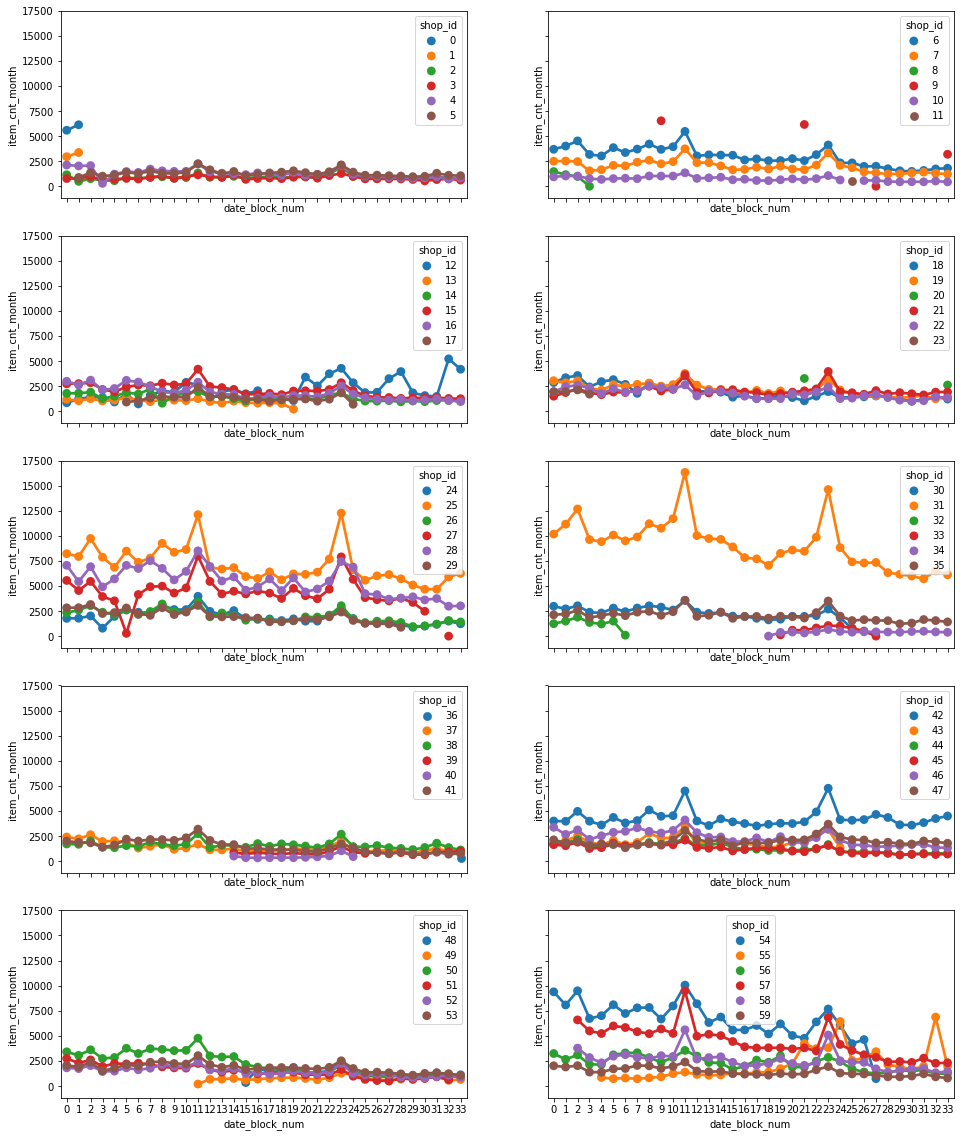

In [7]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
grouped.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

# divide 
num_graph = 10
id_per_graph = np.ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_month', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

A common trends among shops can be found in a few dateblocks

In [8]:
print(train.columns)

# add categories training features
train = train.merge(items, on='item_id', how='left').reset_index().drop(['item_name', 'index'], axis=1)
test = test.merge(items, on='item_id', how='left').reset_index().drop(['item_name', 'index'], axis=1)

# convert date and add
train['month'] = np.int16(train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m')))
train['year'] = np.int16(train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y')))
train.drop('date', axis=1, inplace=True) # days do not affect model as it is on monthly data

print(train.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day',
       'item_category_id', 'month', 'year'],
      dtype='object')


**Visualize the trends in monthly item sales among categories**

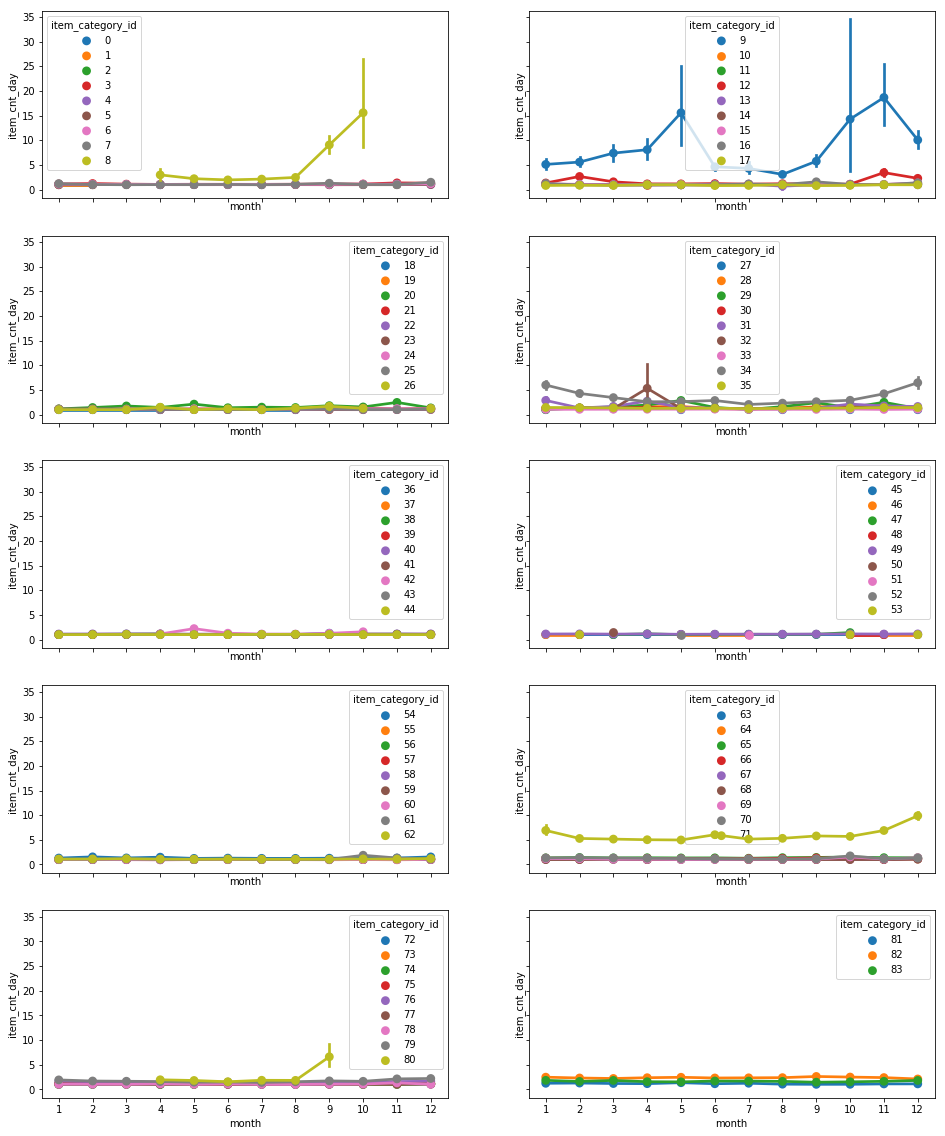

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = np.ceil(train.item_category_id.max() / num_graph)
count = 0

for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

Text(0,0.5,'frequency of data')

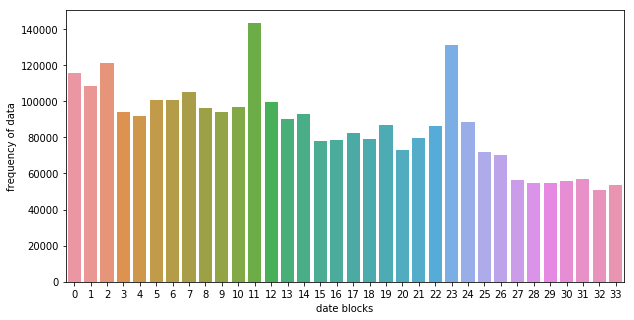

In [10]:
Y = train.groupby(['date_block_num'])['shop_id'].count().values
X = np.arange(len(Y))

plt.figure(figsize=(10,5))
sns.barplot(X, Y)
plt.xlabel('date blocks')
plt.ylabel('frequency of data')

no of examples for each date blocks seems pretty balanced enough for our model

In [11]:
# group by month
train = train.drop(['item_price'], axis=1)

print([c for c in train.columns if c not in ['item_cnt_day']])
train = train.groupby([c for c in train.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
train.info()

['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'month', 'year']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 7 columns):
date_block_num      1609124 non-null int64
shop_id             1609124 non-null int64
item_id             1609124 non-null int64
item_category_id    1609124 non-null int64
month               1609124 non-null int64
year                1609124 non-null int64
item_cnt_month      1609124 non-null float64
dtypes: float64(1), int64(6)
memory usage: 98.2 MB


**Normalize the feature columns**

In [12]:
from sklearn.preprocessing import StandardScaler

def modify_features(data): # reduced rmse score
    # params: data - dataframe, return: modified dataframe
    scaler = StandardScaler()
    
    data['year'] = data['year'] - 2013
    
    for col in data.columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
    
    return data

In [13]:
train = train[train.year != 2013] # drop 2013 from training as they tend to have least effect on the test dateblock
train.drop('date_block_num', axis=1, inplace=True)
# train = modify_features(train)

split training and testing data

In [14]:
from sklearn.model_selection import train_test_split

cols = list(train.columns)
cols.remove('item_cnt_month')

X, Y = train[cols].values, train['item_cnt_month'].values.clip(0, 20)
# Y = Y.clip(0, 20)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((691050, 5), (230350, 5), (691050,), (230350,))

#### Experiment with different models

In [15]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(max_depth=12, n_jobs=-1, learning_rate=0.05, n_estimators=170)
xgb_reg.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=170,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [16]:
print('Training RMSE ', np.sqrt(mean_squared_error(xgb_reg.predict(X_train[:10000]).clip(0, 20), Y_train[:10000])))
print('Validation RMSE', np.sqrt(mean_squared_error(xgb_reg.predict(X_test).clip(0, 20), Y_test)))

Training RMSE  1.5147139497916144
Validation RMSE 1.7354385883637438


In [17]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test)
lgb_params = {
    'feature_fraction': 0.75,
    'metric': 'rmse',
    'nthread':1,
    'min_data_in_leaf': 2**7,
    'bagging_fraction': 0.75,
    'objective': 'mse',
    'bagging_seed': 2**7,
    'num_leaves': 2**7,
    'bagging_freq':1,
    'verbose':0
}

lgb_reg = lgb.train(lgb_params, lgb_train, num_boost_round=1000, valid_sets=lgb_eval, early_stopping_rounds=5)

[1]	valid_0's rmse: 2.48293
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 2.47649
[3]	valid_0's rmse: 2.43136
[4]	valid_0's rmse: 2.40305
[5]	valid_0's rmse: 2.38863
[6]	valid_0's rmse: 2.36636
[7]	valid_0's rmse: 2.36154
[8]	valid_0's rmse: 2.33328
[9]	valid_0's rmse: 2.32134
[10]	valid_0's rmse: 2.30735
[11]	valid_0's rmse: 2.28645
[12]	valid_0's rmse: 2.26749
[13]	valid_0's rmse: 2.25847
[14]	valid_0's rmse: 2.24449
[15]	valid_0's rmse: 2.23423
[16]	valid_0's rmse: 2.22132
[17]	valid_0's rmse: 2.20951
[18]	valid_0's rmse: 2.20412
[19]	valid_0's rmse: 2.1961
[20]	valid_0's rmse: 2.19057
[21]	valid_0's rmse: 2.18214
[22]	valid_0's rmse: 2.17833
[23]	valid_0's rmse: 2.17301
[24]	valid_0's rmse: 2.16901
[25]	valid_0's rmse: 2.16137
[26]	valid_0's rmse: 2.1574
[27]	valid_0's rmse: 2.15372
[28]	valid_0's rmse: 2.1515
[29]	valid_0's rmse: 2.14755
[30]	valid_0's rmse: 2.14444
[31]	valid_0's rmse: 2.14241
[32]	valid_0's rmse: 2.14092
[33]	valid_0's rmse: 2.

In [18]:
def predict(X):
    # improve validation by combining the models
    regs = [xgb_reg, lgb_reg]
    n = len(regs)
    
    preds = np.zeros((X.shape[0]), dtype=np.float64)
    for reg in regs:
        preds += reg.predict(X)
        
    return preds / n

In [19]:
print('Training RMSE ', np.sqrt(mean_squared_error(predict(X_train[:10000]).clip(0, 20), Y_train[:10000])))
print('Validation RMSE', np.sqrt(mean_squared_error(predict(X_test).clip(0, 20), Y_test)))

Training RMSE  1.6359493541892052
Validation RMSE 1.794783494627878


#### prepare test set for submission

In [20]:
test['month'] = 11
test['year'] = 2015

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 6 columns):
ID                  214200 non-null int64
shop_id             214200 non-null int64
item_id             214200 non-null int64
item_category_id    214200 non-null int64
month               214200 non-null int64
year                214200 non-null int64
dtypes: int64(6)
memory usage: 9.8 MB


In [21]:
X = test.drop(['ID'], axis=1).values

In [22]:
test['item_cnt_month'] = predict(X).clip(0, 20)
test['item_cnt_month'].describe()

count    214200.000000
mean          1.501062
std           1.188318
min           0.000000
25%           0.989068
50%           1.202599
75%           1.604062
max          20.000000
Name: item_cnt_month, dtype: float64

In [23]:
test[['ID', 'item_cnt_month']].to_csv('submission.csv', index=False)
test.head()

,ID,shop_id,item_id,item_category_id,month,year,item_cnt_month
0,0,5,5037,19,11,2015,1.052307
1,1,5,5320,55,11,2015,2.813660
2,2,5,5233,19,11,2015,1.235652
3,3,5,5232,23,11,2015,0.920943
4,4,5,5268,20,11,2015,0.688870
